# Is the age actually decreasing? (This is outdated)

In [1]:
import intake
import xarray as xr
import numpy as np
from cmip6_preprocessing.utils import cmip6_dataset_id
from cmip6_preprocessing.preprocessing import combined_preprocessing
from cmip6_preprocessing.postprocessing import (
    match_metrics,
    interpolate_grid_label,
    merge_variables,
    concat_experiments,
)
from cmip6_preprocessing.drift_removal import match_and_remove_trend
from fastprogress.fastprogress import progress_bar

from cmip6_omz.utils import cmip6_collection, o2_models
from cmip6_omz.upstream_stash import (
    pick_first_member,
    construct_static_dz
)
from cmip6_omz.units import convert_mol_m3_mymol_kg

from xarrayutils.file_handling import maybe_create_folder

### needs cleaning
from cmip6_omz.omz_tools import omz_thickness_efficient

In [2]:
# set up dask
from dask.distributed import LocalCluster, Client
mem_total = 128
workers = 2
threads = 4 # 4*6 seemed to work quite well, but I would like this to perform a bit better
cluster = LocalCluster(
    memory_limit=f"{int(mem_total/workers)}GiB",
    dashboard_address=9999,
    threads_per_worker=threads,
    n_workers = workers,
                      )
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:9999/status,
Dashboard: http://127.0.0.1:9999/status,Workers: 2
Total threads: 8,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45609,Workers: 2
Dashboard: http://127.0.0.1:9999/status,Total threads: 8
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:38153,Total threads: 4
Dashboard: http://127.0.0.1:45343/status,Memory: 64.00 GiB
Nanny: tcp://127.0.0.1:34262,


In [29]:
cluster.scale(8)

In [5]:
# if this does not work on jupyter.rc, we can add some logic to
col = cmip6_collection(zarr=False)# TODO: Check with nc files

z_kwargs = {"decode_times": True, "use_cftime": True, "consolidated": True}
n_kwargs = {"decode_times": True, "use_cftime": True, "chunks": {"time": 1}}

variable_ids = ["agessc"]  # "mlotst"
metric_variable_ids = []  # "mlotst"

# models = o2_models()
models = [
     'CanESM5-CanOE',
#      'CanESM5',
#      'CNRM-ESM2-1',
#      'ACCESS-ESM1-5',
#      'MPI-ESM-1-2-HAM',
#      'IPSL-CM6A-LR',
#      'MIROC-ES2L',
#      'UKESM1-0-LL',
#      'MPI-ESM1-2-HR',
#      'MPI-ESM1-2-LR',
#      'MRI-ESM2-0',
#      'NorCPM1',
#      'NorESM1-F',
#      'NorESM2-LM',
#      'NorESM2-MM',
#      'GFDL-CM4',
     'GFDL-ESM4'
]
# models = [m for m in o2_models() if 'GFDL' not in m]
# models = ['ACCESS-ESM1-5']

cat = col.search(
    source_id=models,
    grid_label=["gr", "gn"],
    experiment_id=["historical", "ssp585"],
    table_id=["Omon"],
    variable_id=variable_ids,
)
ds_dict = cat.to_dataset_dict(
    aggregate=False,
    zarr_kwargs=z_kwargs,
    cdf_kwargs=n_kwargs,
    preprocess=combined_preprocessing,
)

# make a separate metric dict to catch all possible metrics!
cat_metrics = col.search(source_id=models, variable_id=metric_variable_ids)
ds_metric_dict = cat_metrics.to_dataset_dict(
    aggregate=False,
    zarr_kwargs=z_kwargs,
    cdf_kwargs=n_kwargs,
    preprocess=combined_preprocessing,
)

Dataframe size before picking latest version: 2363
Getting latest version...

Dataframe size after picking latest version: 2258

Done....


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.dcpp_init_year.version.time_range.path'


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/intake_esm/search.py:106: UserWarning: Query returned zero results.
  warn(message)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/intake_esm/core.py:882: UserWarning: There are no datasets to load! Returning an empty dictionary.
  warn('There are no datasets to load! Returning an empty dictionary.')


In [6]:
import pathlib
# new files (change in later and get rid of `load_trend_dict` (or refactor?) and `fix_trend_metadata`)
# Load all trend files
flist = list(pathlib.Path('../../cmip6_omz/data/external/cmip6_control_drifts/').absolute().glob('*.nc'))
flist = [f for f in flist if any([v in str(f) for v in variable_ids])]
trend_dict = {}
for f in progress_bar(flist):
    trend_dict[f.stem] = xr.open_mfdataset([f])

In [7]:
# these ones are messed up...need a better way to deal with that in the previous step
# see https://github.com/jbusecke/cmip6_preprocessing/issues/175
incomplete_keys = ['CMIP.IPSL.IPSL-CM6A-LR.historical.r3i1p1f1.Omon.gn.none.area_o2']
trend_dict = {k:ds for k,ds in trend_dict.items() if k not in incomplete_keys}

ddict_tracers_detrended = match_and_remove_trend(
    ds_dict,
    trend_dict,
)

In [24]:
ddict_work = concat_experiments(ddict_tracers_detrended)

## Prototype: Fixed mask

In [12]:
import matplotlib.pyplot as plt
from xarrayutils.utils import linear_trend

In [16]:
from cmip6_omz.upstream_stash import construct_static_dz

In [40]:
ds = ddict_work['CanESM5-CanOE.gn.Omon.r1i1p2f1.agessc']
ds = construct_static_dz(ds)

/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [48]:
ds = ds.sel(time=slice('2000', '2100'))
# da = ds.agessc.interp(lev=400)
da = ds.agessc.interp(x=140)

# da = ds.agessc.sel(lev=slice(300, 500))
# da = da.weighted(da.thkcello.fillna(0)).mean(['lev'])

da = linear_trend(da, 'time').slope * 100
p = da.load()

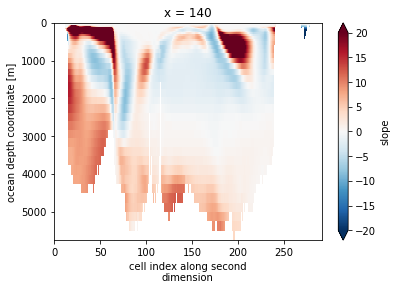

In [49]:
p.plot(vmax=20, yincrease=False)

## Intersect: Check Raw age change in the Pacific

In [6]:
ds_test = ds_dict[
    "ScenarioMIP.CCCma.CanESM5.ssp585.r1i1p2f1.Omon.agessc.gn.v20190429./tigress/GEOCLIM/LRGROUP/jbusecke/projects/cmip_data_management_princeton/builder/../zarr_conversion/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p2f1/Omon/agessc/gn/v20190429/ScenarioMIP.CCCma.CanESM5.ssp585.r1i1p2f1.Omon.agessc.gn.v20190429.zarr"
]
ds_test_detrended = ddict_tracers_detrended[
    "ScenarioMIP.CCCma.CanESM5.ssp585.r1i1p2f1.Omon.agessc.gn.v20190429./tigress/GEOCLIM/LRGROUP/jbusecke/projects/cmip_data_management_princeton/builder/../zarr_conversion/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp585/r1i1p2f1/Omon/agessc/gn/v20190429/ScenarioMIP.CCCma.CanESM5.ssp585.r1i1p2f1.Omon.agessc.gn.v20190429.zarr"
]

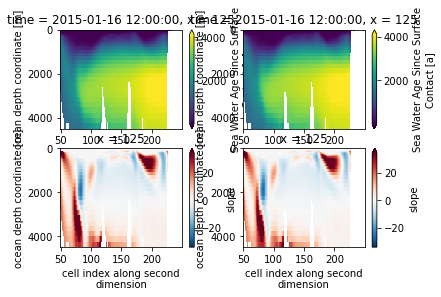

In [10]:
# ## map plots
# roi = dict(lev=15, y=slice(75, 225), x=slice(50,210))
# kwargs=dict(robust=True)

## section plots
# roi = dict(lev=slice(0, 35), y=150, x=slice(75,210))
# find the EUC
# roi = dict(lev=slice(14, 18), y=150, x=slice(75,210))
roi = dict(lev=slice(0, 40), y=slice(50, 250), x=125)
kwargs=dict(robust=True, yincrease=False)



plt.subplot(2,2,1)
ds_test.agessc.isel(time=0, **roi).plot(**kwargs)
plt.subplot(2,2,2)
ds_test_detrended.agessc.isel(time=0, **roi).plot(**kwargs)
plt.subplot(2,2,3)
(linear_trend(ds_test.agessc.isel(**roi).load(), 'time').slope * 100).plot(**kwargs)
plt.subplot(2,2,4)
(linear_trend(ds_test_detrended.agessc.isel(**roi).load(), 'time').slope * 100).plot(**kwargs)

In [31]:
linear_trend(ds_test.o2)

AttributeError: 'Dataset' object has no attribute 'o2'

## Concatenate experiments and pick the first full one

In [ ]:
# somehow xarray cannot deal with comparing list/int attrs (Occurs in CM4)
# I should raise that, but lets fix it quickly here
def clean_attrs(ds):
    for a, attr in ds.attrs.items():
        if isinstance(attr, int):
            ds.attrs[a] = [attr]
    return ds

ddict_matched_regrid = {k:clean_attrs(ds) for k, ds in ddict_matched_regrid.items()}

ddict_ex_combined = concat_experiments(
    ddict_matched_regrid,
    concat_kwargs={
        'combine_attrs': 'drop_conflicts',
        'compat': 'override',
        'coords': 'minimal'
    }
)

In [ ]:
ddict_ex_combined.keys()

Still need to deal with the access stuff here...

In [ ]:
# only pick full runs (historical and ssp585)
ddict_ex_combined_full = {k:ds for k,ds in ddict_ex_combined.items() if len(ds.time)>3000}

## Check for problems and fix missing area/thickness manually

This should be wrapped and brought upstream

In [ ]:
from cmip6_preprocessing.grids import combine_staggered_grid
problems = {'missing_variables':[], 'missing_area':[], 'missing_thickness':[], 'reconstructed_area':[], 'reconstructed_thickness':[]}
ddict_filtered = {}
for name, ds in ddict_ex_combined_full.items():
    flag = False
    # Check that all necessary variables are given
    missing_variables = [va for va in ["thetao", "so", "o2"] if va not in ds.variables]
    if len(missing_variables)>0:
        flag = True
        problems['missing_variables'].append((name, missing_variables))
        
    # Check for area
    if not 'areacello' in ds.coords:
        if ds.attrs['grid_label'] == 'gr': # only reconstruct for regular grids
            grid, ds = combine_staggered_grid(ds, recalculate_metrics=True)
            # I am dropping dz_t here so it can be uniformly reconstructed
            ds = ds.drop('dz_t')
            ds = ds.assign_coords(areacello = (ds.dx_t * ds.dy_t).reset_coords(drop=True))
            problems['reconstructed_area'].append(name)
            assert 'areacello' in ds.coords
        else:
            flag = True
            problems['missing_area'].append(name)
    
    # Check for thickness (and rename) TODO: We should probably not rename and just refactor to use `thkcello`
    if "thkcello" in ds.coords:
        ds = ds.rename({'thkcello': 'dz_t'})
    else:
        # try to reconstruct the thickness from static info
        try:
#             lev_vertices = cf_xarray.bounds_to_vertices(ds.lev_bounds, 'bnds').load()
#             dz_t = lev_vertices.diff('lev_vertices')
#             ds = ds.assign_coords(dz_t=('lev', dz_t.data))
            ds = construct_static_dz(ds).rename({'thkcello': 'dz_t'})
            problems['reconstructed_thickness'].append(name)
        except Exception as e:
            print(f'{name} thickness reconstruction failed with {e}')
            print(ds)
            problems['missing_thickness'].append(name)
            flag=True
            
    if not flag:
        ddict_filtered[name] = ds

In [ ]:
ddict_final = pick_first_member(ddict_filtered)#
list(np.sort(list(ddict_final.keys())))

## Prep Basin mask
- Needs a separated Indian Ocean (Sam uses: 78E)
- Refactor with the new masking using cf-xarray

In [ ]:
# load ocean basin data
import regionmask
basins = regionmask.defined_regions.natural_earth.ocean_basins_50
from cmip6_preprocessing.regionmask import merged_mask

## Define bins

In [ ]:
o2_bins = np.hstack([-100, np.arange(5, 160, 5)])  # in mymol/kg
o2_bins_converted = bins_converted = (
    o2_bins / convert_mol_m3_mymol_kg(xr.DataArray([1])).data
)

# define mask bins
mask_bins = np.arange(-0.5, 13.0, 1)# for now manual, but maybe there is a clever way to do this?
mask_bins

lat_bins = np.arange(-60, 91, 20)
lat_bins

## This needs to go within the loop later


- I need to also make sure nans are appropriately masked between variables

In [ ]:
def check_exist(path):
#     return path.exists()
# hack for CM4
    return False

In [ ]:
for name, ds in ddict_final.items():
#     ds = ds.chunk({'time':1, 'x':720, 'y':576})
    ds = ds.reset_coords('dz_t')
    mask = merged_mask(basins, ds)
    mask.name = "basin_mask"

    # Create a dataset
    vol = ds.dz_t * ds.areacello

    count = histogram(
        ds.o2,
        ds.lat,
        mask,
        bins=[o2_bins_converted, lat_bins, mask_bins],
        dim=["x", "y"],
    )
    volume = histogram(
        ds.o2,
        ds.lat,
        mask,
        bins=[o2_bins_converted, lat_bins, mask_bins],
        weights=vol,
        dim=["x", "y"],
    )
    tracers = {}
    for tr in ds.data_vars:
        tracers[tr] = histogram(
            ds.o2,
            ds.lat,
            mask,
            bins=[o2_bins_converted, lat_bins, mask_bins],
            weights=ds[tr] * vol,
            dim=["x", "y"],
        )
    ds_hist = xr.Dataset(dict(count=count, volume=volume, **tracers))
    ds_hist.attrs = {k:v for k,v in ds.attrs.items() if k not in ['intake_esm_varname']}
    print(f"{ds_hist.nbytes/1e9} GB")
    path = ofolder.joinpath(f"{cmip6_dataset_id(ds_hist)}")
    if not check_exist(path):
        print(path)
#         append_write_zarr(ds_hist, path, 60)
        append_write_zarr(ds_hist, path, 1) # just for CM4

In [ ]:
stop here

## Test the output against something I know

This seems fine. The bin count is not exact, but that is probably due to some changes in the numerical precision in one of the methods.

Nice the mean tracer values also line up.

In [ ]:
# might need to rename a few here so that it works and the dataset should probably be synth 
# Then I can move this to the tests.

# define mask bins
mask_bins = np.arange(-0.5, 13.0, 1)# for now manual, but maybe there is a clever way to do this?
mask_bins

lat_bins = np.arange(-90, 91, 20)
lat_bins

lev_bins = np.arange(0, 7000, 500)
lev_bins
vol = (ds.dz_t*ds.areacello) 

count = histogram(ds.o2, ds.lat, mask, bins=[o2_bins_converted, lat_bins, mask_bins], dim=['x','y'])
volume = histogram(ds.o2, ds.lat, mask, bins=[o2_bins_converted, lat_bins, mask_bins], weights=vol, dim=['x','y'])
tracers = {}
for tr in ds.data_vars:
    tracers[tr] = histogram(ds.o2, ds.lat, mask, bins=[o2_bins_converted, lat_bins, mask_bins], weights=ds[tr]*vol, dim=['x','y'])

In [ ]:
from cmip6_omz.omz_tools import mask_basin

In [ ]:
# expected_threshold = 0.082
cutoff = o2_bins_converted[-1]
test_full_pacific = test
# expected_full_pacific = mask_basin(ds.o2.isel(time=0), drop=False)
expected_full_pacific = ds.o2
expected_full_pacific = xr.ones_like(expected_full_pacific).where(expected_full_pacific<=cutoff)

In [ ]:
test

In [ ]:
expected_full_pacific

In [ ]:
ds.o2.shape

In [ ]:
expected_full_pacific.shape

In [ ]:
test_full_pacific.sum().data/expected_full_pacific.sum().load().data

I suspect this is due to the numerial precision going wrong somewhere...

In [ ]:
test

In [ ]:
# example with masked basin
cutoff = o2_bins_converted[-3]
test_full_pacific = test.sel(basin_mask_bin=slice(1.5, 3.5))
expected_full_pacific = mask_basin(ds.o2, drop=False)
expected_full_pacific = xr.ones_like(expected_full_pacific).where(expected_full_pacific<=cutoff)

In [ ]:
test_full_pacific.sum().data/expected_full_pacific.sum().load().data

In [ ]:
# example with masked basin
cutoff = o2_bins_converted[-3]
test_full_pacific = test3.sel(basin_mask_bin=slice(1.5, 3.5)).sum()/test2.sel(basin_mask_bin=slice(1.5, 3.5)).sum()
expected_full_pacific = mask_basin(ds, drop=False)
expected_full_pacific = expected_full_pacific.where(expected_full_pacific<=cutoff)
expected_full_pacific = expected_full_pacific.o2.weighted((expected_full_pacific.areacello*expected_full_pacific.dz_t).fillna(0)).mean()

In [ ]:
expected_full_pacific.load()

In [ ]:
test_full_pacific

## synthetic example for xhistogram

I somehow cannot bin over 'lev'...ok for now. Problem is described in detail [here](https://github.com/xgcm/xhistogram/issues/16)

In [ ]:
# I cant get the count numbers to line up. What am I doing wrong here?
da = xr.DataArray(np.random.rand(400,76), name='test')
cutoff = 0.4
hist = histogram(da, bins=np.array([-1e3, cutoff]))
hist

In [ ]:
test = xr.ones_like(da).where(da<=cutoff).sum()
test

In [ ]:
da.plot()